In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import torch.nn.functional as F


In [2]:
# ====== CONFIG ======
DATA_DIR = "splits"
BATCH_SIZE = 32
IMAGE_SIZE = 224
EPOCHS = 15
LR = 1e-4
MODEL_PATH = "best_resnet50_sneakers.pt"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
# ====== TRANSFORMS ======
train_tfms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [6]:
# ====== LOADERS ======
print(os.path.join(DATA_DIR, "train"))
train_data = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_tfms)
val_data = datasets.ImageFolder(os.path.join(DATA_DIR, "val"), transform=val_tfms)
test_data = datasets.ImageFolder(os.path.join(DATA_DIR, "test"), transform=val_tfms)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

num_classes = len(train_data.classes)
print(f"Classes: {num_classes} | Device: {DEVICE}")



splits\train
Classes: 50 | Device: cuda


In [7]:
# ====== MODEL ======
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, num_classes)
)
model = model.to(DEVICE)


In [ ]:
# ====== TRAIN SETUP ======
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=LR)

best_acc = 0
train_losses, val_losses, val_accuracies = [], [], []


In [41]:
# ====== TRAINING LOOP ======
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # ====== VALIDATION ======
    model.eval()
    val_loss = 0.0
    preds, targets = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds.extend(torch.argmax(outputs, 1).cpu().numpy())
            targets.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    acc = accuracy_score(targets, preds)
    val_losses.append(val_loss)
    val_accuracies.append(acc)

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val Acc={acc:.4f}")

    # ====== SAVE BEST ======
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), MODEL_PATH)
        print(f"✔ Saved new best model (Acc={best_acc:.4f})")

    #remove if retraining
    scheduler.step()  # reduce LR every 3 epochs



Epoch 1/15: 100%|██████████| 149/149 [00:37<00:00,  4.01it/s]


Epoch 1: Train Loss=0.0769, Val Loss=0.7684, Val Acc=0.8021


Epoch 2/15: 100%|██████████| 149/149 [00:37<00:00,  3.99it/s]


Epoch 2: Train Loss=0.0662, Val Loss=0.7617, Val Acc=0.7916


Epoch 3/15: 100%|██████████| 149/149 [00:36<00:00,  4.04it/s]


Epoch 3: Train Loss=0.0648, Val Loss=0.7873, Val Acc=0.7881


Epoch 4/15: 100%|██████████| 149/149 [00:36<00:00,  4.03it/s]


Epoch 4: Train Loss=0.0576, Val Loss=0.7625, Val Acc=0.8039


Epoch 5/15: 100%|██████████| 149/149 [00:37<00:00,  4.02it/s]


Epoch 5: Train Loss=0.0548, Val Loss=0.7693, Val Acc=0.7968


Epoch 6/15: 100%|██████████| 149/149 [00:37<00:00,  4.02it/s]


Epoch 6: Train Loss=0.0514, Val Loss=0.7746, Val Acc=0.8056
✔ Saved new best model (Acc=0.8056)


Epoch 7/15: 100%|██████████| 149/149 [00:37<00:00,  4.01it/s]


Epoch 7: Train Loss=0.0457, Val Loss=0.7675, Val Acc=0.8004


Epoch 8/15: 100%|██████████| 149/149 [00:37<00:00,  4.02it/s]
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000002B883E52B00>
Traceback (most recent call last):
  File "c:\Users\MAHDI\anaconda3\envs\sneaker\lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "c:\Users\MAHDI\anaconda3\envs\sneaker\lib\site-packages\torch\utils\data\dataloader.py", line 1562, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


KeyboardInterrupt: 

In [8]:
# ====== TEST EVALUATION ======
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()
preds, targets = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        preds.extend(torch.argmax(outputs, 1).cpu().numpy())
        targets.extend(labels.cpu().numpy())
test_acc = accuracy_score(targets, preds)
print(f"Test Accuracy: {test_acc:.4f}")


C:\Users\MAHDI\AppData\Local\Temp\ipykernel_28880\115720643.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH))


Test Accuracy: 0.8031


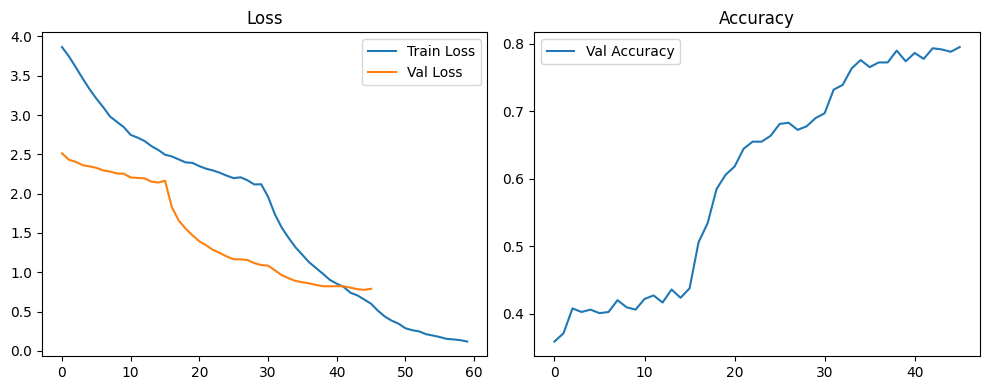

In [36]:
# ====== PLOTS ======
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Accuracy")

plt.tight_layout()
plt.savefig("training_curves.png", dpi=150)
plt.show()


In [ ]:
#load model
num_classes = 50  # your dataset classes

# Rebuild architecture
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, num_classes)
)

# Load weights
model.load_state_dict(torch.load("best_resnet50_sneakers.pt", map_location="cuda"))

# Move to GPU and set to eval mode
model = model.to("cuda")
model.eval()

print("Model loaded and ready.")


C:\Users\MAHDI\AppData\Local\Temp\ipykernel_13772\3628081385.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_resnet50_sneakers.pt

Model loaded and ready.


In [26]:

# Unfreeze last two layers of ResNet
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)


In [40]:
# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

# Use a smaller learning rate for full fine-tuning
optimizer = optim.Adam(model.parameters(), lr=1e-5)


In [38]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)


In [ ]:
#data download
from roboflow import Roboflow
rf = Roboflow(api_key="e4ZZli4oTPqXNqaHf6Pv")
project = rf.workspace("ggdgdsgdg").project("original-or-fake-shoes")
version = project.version(9)
dataset = version.download("yolov8")
                

   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.3/38.8 MB ? eta -:--:--
   - -------------------------------------- 1.0/38.8 MB 2.8 MB/s eta 0:00:14
   - -------------------------------------- 1.6/38.8 MB 2.8 MB/s eta 0:00:14
   -- ------------------------------------- 2.1/38.8 MB 2.9 MB/s eta 0:00:13
   -- ------------------------------------- 2.6/38.8 MB 2.9 MB/s eta 0:00:13
   --- ------------------------------------ 3.4/38.8 MB 2.9 MB/s eta 0:00:13
   ---- ----------------------------------- 3.9/38.8 MB 2.9 MB/s eta 0:00:12
   ---- ----------------------------------- 4.7/38.8 MB 2.9 MB/s eta 0:00:12
   ----- ---------------------------------- 5.2/38.8 MB 2.9 MB/s eta 0:00:12
   ----- ---------------------------------- 5.8/38.8 MB 2.9 MB/s eta 0:00:12
   ------ --------------------------------- 6.3/38.8 MB 2.9 MB/s eta 0:00:12
   ------- -------------------------------- 7.1/38.8 MB 2.9 MB/s eta 0:00:11
   ------- --


Extracting Dataset Version Zip to Original-or-Fake-Shoes-9 in yolov8:: 100%|██████████| 7764/7764 [00:05<00:00, 1358.04it/s]


In [16]:
#try out model on test data
# ====== SINGLE IMAGE TEST ======
img_path = "vans.jpg"  # change this
img = Image.open(img_path).convert("RGB")

# use same validation transforms
img_t = val_tfms(img).unsqueeze(0).to(DEVICE)

# predict
model.eval()
with torch.no_grad():
    output = model(img_t)
    probs = F.softmax(output, dim=1)
    pred_class = torch.argmax(probs, 1).item()

# map index to class label
class_name = train_data.classes[pred_class]

print(f"Predicted: {class_name} | Confidence: {probs[0][pred_class]:.3f}")


Predicted: vans_old_skool | Confidence: 0.408
